# CS448 - Lab 9: Spectral Factorizations

## Part 1. Learning Spectral Components

In this part we will design a simple component analyzer. Use the sound file [ https://drive.google.com/uc?export=download&id=1fyHhUqYVOrIPzSMJoQC78sqeokjqI4ib ]. This is a drum loop with four distinct sounds (bass drum, snare drum, cymbal and synthetic bell sound). We will use a spectral factorization that will allow us to extract them all. Obtain the STFT of this signal and use a DFT size of 4096, a hop size of 256 and a Hann window. This will be stored in a matrix $\mathbf F$ whose size will be $M$ by $N$. 

You now need to implement a factorization technique. This is defined as:

$$|\mathbf F | \approx \mathbf{W} \cdot \mathbf{H}$$
$$\mathbf{F} \in \mathbb{R}^{M\times N}_+, \mathbf{W} \in \mathbb{R}^{M\times K}_+, \mathbf{H} \in \mathbb{R}^{K\times N}_+$$

Where $\mathbb{R}^{A\times B}_+$ is the set of matrices of size $A \times B$ containing non-negative elements, and $|\mathbf{F}|$ takes the absolute value of the STFT matrix $\mathbf{F}$.  In this case we will use $K$=4 since the mix we are analyzing has four distinct sounds.  To estimate the values of $\mathbf{W}$ and $\mathbf{H}$ start by filling them with uniformly random values between 10 to 11 and iterate over the following equations:

$$\mathbf{V} = \frac{|\mathbf{F}|}{\mathbf{W}\cdot \mathbf{H} + \epsilon}$$
$$\mathbf{H} = \mathbf{H} \odot \left[ \mathbf{W}^\top \cdot \mathbf{V} \right]$$
$$\mathbf{W} = \mathbf{W} \odot \left[ \mathbf{V} \cdot \mathbf{H}^\top \right]$$

Where $\odot$ denotes element-wise multiplication and the fraction performs element-wise division.  The constant $\epsilon$ is assigned to a small value (e.g. 1e-7) to avoid division by zero. After each pass normalize the columns of $\mathbf{W}$ to sum to 1.  Iterate for about 100 times.

Plot the columns of $\mathbf{W}$ and explain what they correspond to. Plot the rows of $\mathbf{H}$ and explain them as well. You might have to run the above procedure a couple of times since in some cases the results can come up wrong. Just to be safe, run this a dozen times and show the results that are representative of the majority of the outputs (note that each time the ordering will be different, we only care about the shapes of these quantities, not their order).

You can now try to extract each component. Take each column of $\mathbf{W}$ and compute its outer product with its corresponding row of $\mathbf{H}$. This will approximate only one component of the input spectrogram. Plot all four products and explain what they look like. Use the phase of the original input to invert these resulting spectrograms to the time domain and listen to them. What do they sound like?

In [56]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np

In [25]:
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label == '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

def wavreadurl( url):
    import urllib.request, io, scipy.io.wavfile
    f = urllib.request.urlopen( urllib.request.Request( url))
    sr,s = scipy.io.wavfile.read( io.BytesIO( f.read()))
    return sr, s.astype( 'float32')/32768

In [26]:
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    return np.hstack(f)

def istft(stft_output, dft_size, hop_size, zero_pad, window):
    t = []
    for f in stft_output.T:
        t.append(np.fft.irfft(f, dft_size+zero_pad))
    t = np.array(t)

    x = np.zeros(dft_size+hop_size*(len(t)-1))
    for i in range(len(t)):
        x[i*hop_size:i*hop_size+dft_size] += t[i][:dft_size] * window
    
    return x[dft_size:]

def plot_spectrogram(x, X, fs, title=''):
    time_axis = np.linspace(0, len(x)/fs, X.shape[1])
    freq_axis = np.linspace(0, fs/2, X.shape[0])
    freq_abs = np.absolute(X)

    plt.pcolormesh(time_axis, freq_axis, np.log(freq_abs+1e-5), cmap='Blues')

    plt.title(title)
    plt.xlabel('Time (sec)')
    plt.ylabel('Freq (Hz)')

    plt.show()
    
def spectral_factorization(F, K, init_value, iteration):
    M, N = F.shape

    W = np.random.rand(M, K) + init_value
    H = np.random.rand(K, N) + init_value

    for i in range(iteration):
        V = np.abs(F) / (W @ H + 1e-7)
        H = H * (W.T @ V)
        W = W * (V @ H.T)
        for col in range(W.shape[1]):
            W[:, col] /= np.sum(W[:, col])

    return W, H

In [27]:
dft_size = 4096
hop_size = 256
zero_pad = 0
stft_window = signal.windows.hann(dft_size, sym=False)
K = 4
init_value = 10.0
iteration = 100

url = 'https://drive.google.com/uc?export=download&id=1fyHhUqYVOrIPzSMJoQC78sqeokjqI4ib'
fs, x = wavreadurl(url)
F = stft(x, dft_size, hop_size, zero_pad, stft_window)

W, H = spectral_factorization(F, K, init_value, iteration)

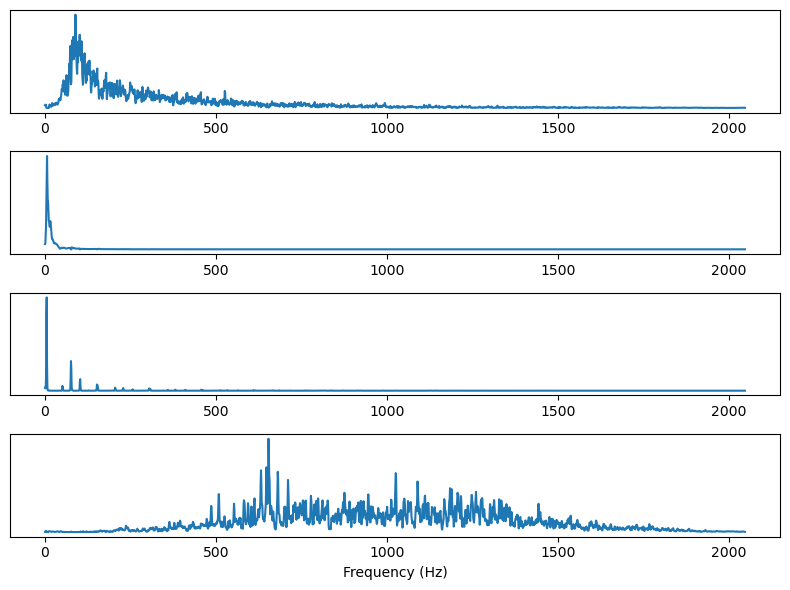

In [29]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))

for col in range(W.shape[1]):
    axs[col].plot(W[:, col])
    axs[col].set_yticks([])

axs[3].set_xlabel('Frequency (Hz)')
fig.tight_layout()
plt.show()

First component: snare drum. The spectrum has a dominant peak at a low frequency.

Second component: bass drum. The spectrum contains a single pulse at a very low frequency.

Third component: synthetic bell. The energy of the spectrum is concentrated at a low pitch, while there are some secondary peaks at frequencies around the impulse.

Fourth component: cymbal. The energy of the spectrum spread over frequencies in the middle, while there is some slightly fricative noise.

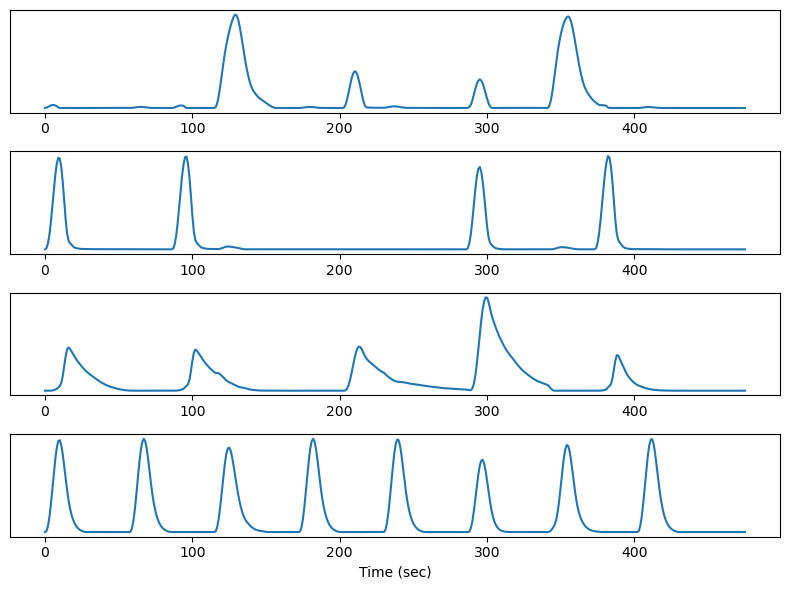

In [30]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))

for row in range(H.shape[0]):
    axs[row].plot(H[row])
    axs[row].set_yticks([])

axs[3].set_xlabel('Time (sec)')
fig.tight_layout()
plt.show()

First component: snare drum. There are 2 snare drum sounds, each period contains a light hit and a strong hit.

Second component: bass drum. There are 2 beats at the beginning, a silence period, and 2 beats at the end.

Third component: synthetic bell. There are 5 bell sounds and the fourth one is the strongest one.

Fourth component: cymbal. Thy cymbal displays an even periodic pattern.

In [31]:
C = []
for i in range(K):
    C.append(np.outer(W[:, i], H[i]))

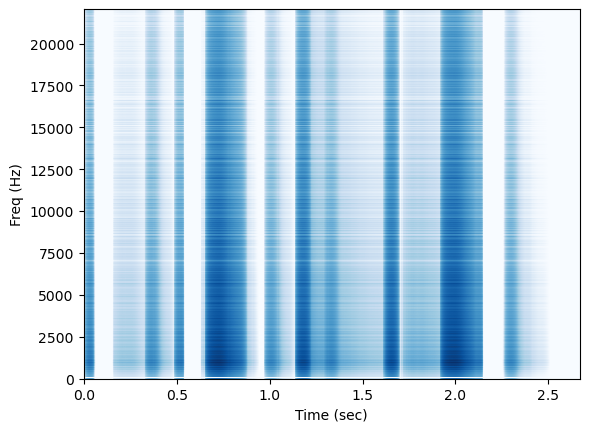

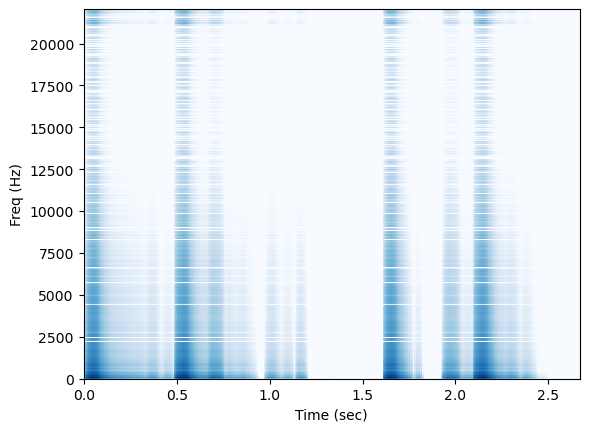

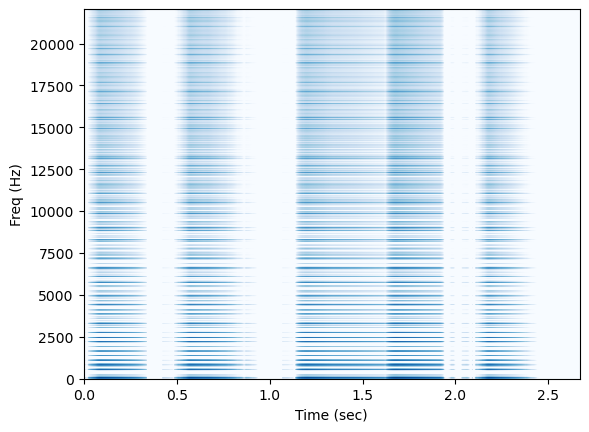

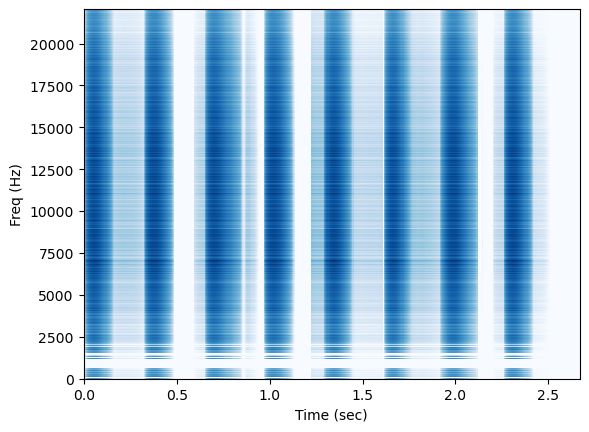

In [32]:
for Ci in C:
    plot_spectrogram(x, Ci, fs)

First component: snare drum\
Second component: bass drum\
Third component: synthetic bell\
Fourth component: cymbal.

In [33]:
Y = []
for Ci in C:
    mag = np.abs(Ci)
    phase = np.angle(F)
    Yi = mag * np.exp(1j * phase)
    Y.append(Yi)
    
y = []
for Yi in Y:
    yi = istft(Yi, dft_size, hop_size, zero_pad, window=1/2)
    y.append(yi)

In [55]:
sound(y[0], fs, 'snare drum')
sound(y[1], fs, 'bass drum')
sound(y[2], fs, 'synthetic bell')
sound(y[3], fs, 'cymbal')

snare drum


bass drum


synthetic bell


cymbal


## Part 2: Training Dictionaries for Source Separation

In this section we will design a system that separates speech of a known speaker from a known type of noise. Use the sound files [ https://drive.google.com/uc?export=download&id=1fhTSrXDDbsp06oqlrBL9p9JToC4Mws11 ] and [ https://drive.google.com/uc?export=download&id=1fmtVWSLp5ZB5_pkFvr8BEXSj0bRuNe70 ] from the lab archive.

One of them is of speech and the other one of chimes. Take the first sentence of the speech sound and a segment which is just as long from the beginning of the chime sound and add them together. This will be a mixture that we will try to separate. The rest of the data we will use for training dictionary models.
Taking the rest of the speech data run a factorization as we’ve done above with $K$ = 40. Do the same with the remaining chime sound. From these you will obtain two matrices $\mathbf{W}_s$ and $\mathbf{W}_c$. These are the dictionaries of the two sounds. If you visually inspect them you will see that they look a lot like representative spectra of these two sounds.

In order to resolve the mixture we need to use these dictionaries to explain its spectrogram and then only use each dictionary’s contribution to resynthesize a time signal. This essentially involves finding the $\mathbf{H}$ matrix while fixing the $\mathbf{W}$ matrix to be a concatenation of $\mathbf{W}_s$ and $\mathbf{W}_c$. You can do that using the iterative approach used in the previous part, but only updating $\mathbf{H}$ and not updating $\mathbf{W}$ at every iteration. If you do this on the mixture you will ultimately get a $\mathbf{H}$ that will let us know how to combine the elements of the pretrained dictionaries to approximate the input.

To extract the two sounds you need to isolate the contribution of the two dictionaries on the mixture. That will be $\mathbf{F}_s = \mathbf{W}_s \cdot \mathbf{H}_s$ and $\mathbf{F}_c = \mathbf{W}_c \cdot \mathbf{H}_c$, where $\mathbf{H}_s$ corresponds to the first 40 rows of $\mathbf{H}$ and $\mathbf{H}_c$ to its second 40 rows. $\mathbf{F}_s$ and $\mathbf{F}_c$  will correspond to the magnitude spectrograms of the two extracted sources. Just as before use the phase of the input mixture to invert these back to the time domain and listen to them. Do they sound like they are separated? Play around with the STFT parameters until you get the best sounding results.

In [45]:
def spectral_factorization_with_dictionary(F, W, init_value, iteration):
    M, N = F.shape
    M, K = W.shape
    epsilon = 1e-7

    H = np.random.rand(K, N) + init_value

    for i in range(iteration):
        V = np.abs(F) / (W @ H + epsilon)
        H = H * (W.T @ V)
        
    return H

In [ ]:
url1 = 'https://drive.google.com/uc?export=download&id=1fhTSrXDDbsp06oqlrBL9p9JToC4Mws11'
url2 = 'https://drive.google.com/uc?export=download&id=1fmtVWSLp5ZB5_pkFvr8BEXSj0bRuNe70'

fs_s, s = wavreadurl(url1)
fs_c, c = wavreadurl(url2)

m = s[:seg_index] + c[:60000]
s_train = s[60000:]
c_train = c[60000:]

sound(m, fs_s, 'source')

In [49]:
dft_size = 1024
hop_size = 256
zero_pad = 0
stft_window = signal.windows.hann(dft_size, sym=False)

S = stft(s_train, dft_size, hop_size, zero_pad, stft_window)
C = stft(c_train, dft_size, hop_size, zero_pad, stft_window)

K = 40
W_s, H_s = spectral_factorization(S, K, init_value, iteration)
W_c, H_c = spectral_factorization(C, K, init_value, iteration)

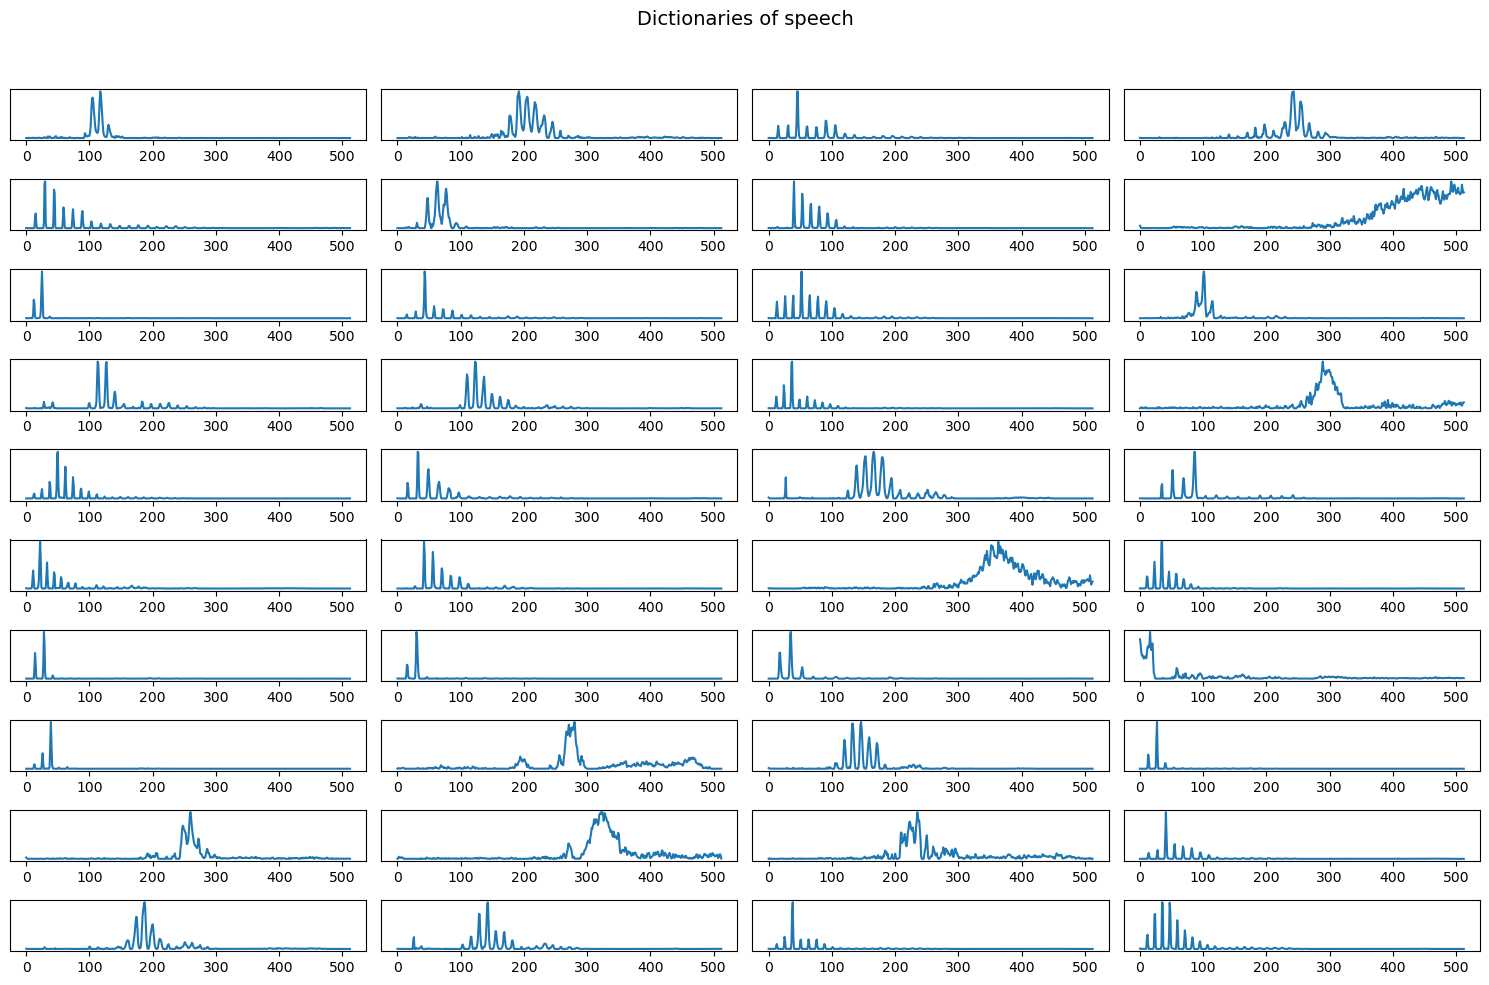

In [58]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(15, 10))

for col in range(W_s.shape[1]):
    axs[col%10][col//10].plot(W_s[:, col])
    axs[col%10][col//10].set_yticks([])

fig.suptitle('Dictionaries of speech', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

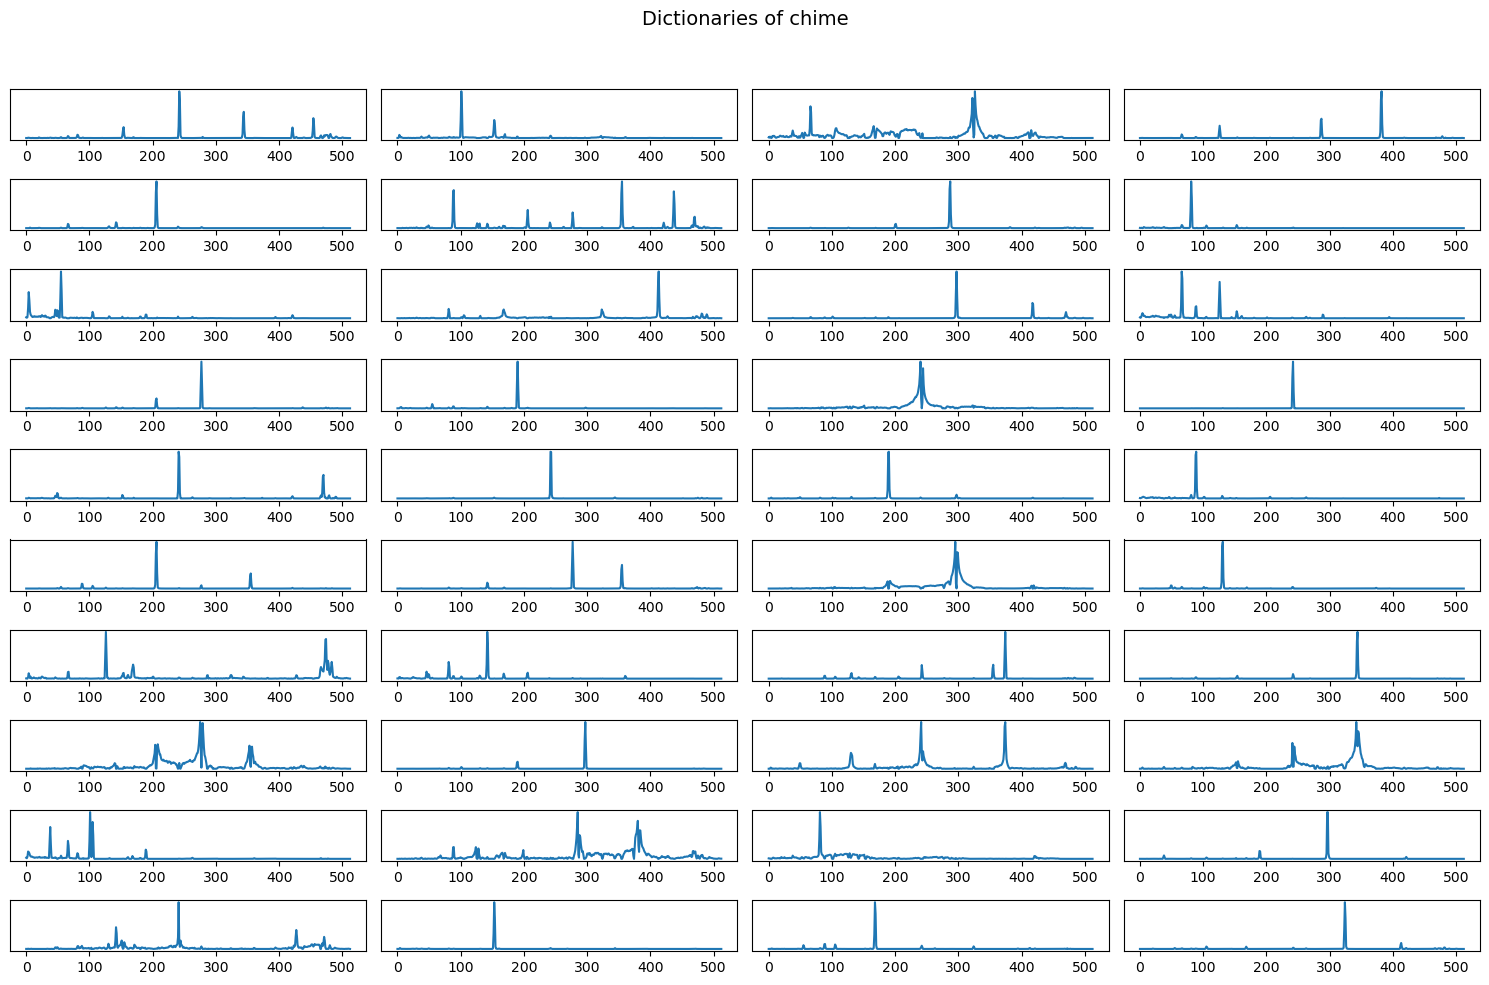

In [57]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(15, 10))

for col in range(W_c.shape[1]):
    axs[col%10][col//10].plot(W_c[:, col])
    axs[col%10][col//10].set_yticks([])

fig.suptitle('Dictionaries of chime', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [53]:
F = stft(m, dft_size, hop_size, zero_pad, stft_window)
W = np.hstack((W_s, W_c))

H = spectral_factorization_with_dictionary(F, W, init_value=10.0, iteration=100)

F_s = W_s @ H[:K]
F_c = W_c @ H[K:]

Y_s = np.abs(F_s) * np.exp(1j * np.angle(F))
Y_c = np.abs(F_c) * np.exp(1j * np.angle(F))

y_s = istft(Y_s, dft_size, hop_size, zero_pad, window=1/2)
y_c = istft(Y_c, dft_size, hop_size, zero_pad, window=1/2)

In [54]:
sound(y_s, fs_s, 'seperated speech')
sound(y_c, fs_c, 'seperated chime')

seperated speech


seperated chime


They sound like they are separated.